<a href="https://colab.research.google.com/github/mgnarag/painting_restoration/blob/main/unet_rgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!ls drive/My\ Drive
file_path = "/content/drive/MyDrive/Baumgartner screenshots/"

In [3]:
import time
import pandas as pd


import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


from PIL import Image, ImageOps
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

import cv2
from skimage import color

from tensorflow import keras
from PIL import Image, ImageOps
import numpy as np
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 236958876

In [4]:
def zoom_and_resize(img, zoom_factor):
    height, width = img.shape[:2]

    # Calculate the region to crop around the center
    crop_top = int((height - height / zoom_factor) / 2)
    crop_bottom = int(height - crop_top)
    crop_left = int((width - width / zoom_factor) / 2)
    crop_right = int(width - crop_left)
    # Crop the image
    cropped_image = img[crop_top:crop_bottom, crop_left:crop_right]
    # Resize the zoomed image back to the original dimensions
    resized_image = cv2.resize(cropped_image, (width, height))

    return resized_image

def crop(im):
    width, height = im.size
    data = []
    step = int(size * 0.5)  # Adjust the step size for cropping

    for j in range(0, height, step):
        for i in range(0, width, step):
            if i + size <= width and j + size <= height:
                im1 = im.crop((i, j, i + size, j + size))
                im1 = np.array(im1).astype(np.float32)
                data.append(im1/255)
                im1 = np.rot90(im1)
                data.append(im1/255)
                im1 = np.rot90(im1)
                data.append(im1/255)
                im1 = np.rot90(im1)
                data.append(im1/255)
                for z in zoom_factor:
                    zoomed_img = zoom_and_resize(im1, z)
                    data.append(zoomed_img/255)
            #flip_im1 = np.fliplr(im1)

    return data

def rgb_lab_normalized(im):
    rgb_array = np.array(im) # Convert to numpy array
    rgb_array_normalized = rgb_array / 255.0 # Normalize RGB values from 0 to 1
    lab_array_normalized = color.rgb2lab(rgb_array_normalized) # Convert RGB to LAB colorspace
    # Scale LAB values to range [0, 1]
    lab_array_normalized[..., 0] = (lab_array_normalized[..., 0]) / 100.0
    lab_array_normalized[..., 1] = (lab_array_normalized[..., 1] + 128) / 255.0
    lab_array_normalized[..., 2] = (lab_array_normalized[..., 2] + 128) / 255.0
    lab_image_normalized = Image.fromarray((lab_array_normalized * 255).astype(np.uint8), mode='LAB')# Convert LAB array back to image
    return lab_image_normalized

In [ ]:
epoch = 100
model_number = 32
size = 32


# Generate augmented images with specific rotations
#zoom_factor = [x/5 for x in range(6, 8)]
zoom_factor = [1.50,2.0, 2.50, 3.0]



data = []

input = Image.open(file_path + "Training/TRAIN_INPUT_[04] Coming into Bloom.png").convert('RGB')
input = np.array(crop(rgb_lab_normalized(input)))
print("Done reading the input of size = ", input.shape)

output = Image.open(file_path + "Training/TRAIN_OUTPUT_[04] Coming into Bloom.png").convert('RGB')
output = np.array(crop(rgb_lab_normalized(output)))
print("Done reading the input of size = ", output.shape)


train_input = []
test_input = []
for i in range(0,len(input)):
    if i % 4 == 0:
        test_input.append(input[i])
    else:
        train_input.append(input[i])

train_input = np.array(train_input)
test_input = np.array(test_input)

print("Done reading the train input of size = ", train_input.shape)
print("Done reading the test input of size = ", test_input.shape)
input = []

train_output = []
test_output = []
for i in range(0,len(output)):
    if i % 4 == 0:
        test_output.append(output[i])
    else:
        train_output.append(output[i])

train_output = np.array(train_output)
test_output = np.array(test_output)

print("Done reading the train output of size = ", train_input.shape)
print("Done reading the test output of size = ", test_input.shape)

output = []


Done reading the input of size =  (32370, 32, 32, 3)
Done reading the input of size =  (32370, 32, 32, 3)
Done reading the train input of size =  (24277, 32, 32, 3)
Done reading the test input of size =  (8093, 32, 32, 3)
Done reading the train output of size =  (24277, 32, 32, 3)
Done reading the test output of size =  (8093, 32, 32, 3)


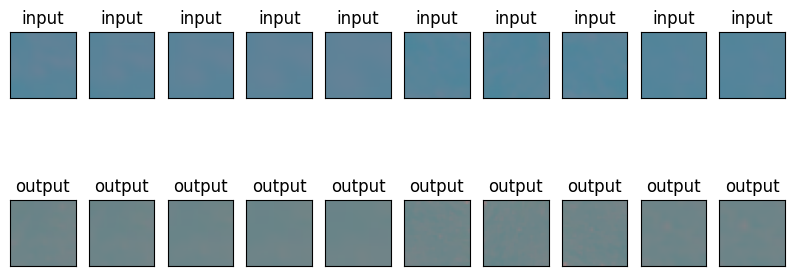

In [ ]:
N = 1000
n = 10
plt.figure(figsize=(10, 4))
for i in range(0,10):

    ax = plt.subplot(2, n, i + 1)


    plt.title("input")
    plt.imshow((train_input[i+N]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, i + n + 1)
    plt.title("output")
    plt.imshow((train_output[i+N]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()



In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization
from tensorflow.keras import layers, losses
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

def unet_model(input_shape=(size, size, 3)):
    inputs = Input(input_shape)

    # Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', strides = 2)(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', strides = 2)(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    #conv4 = Conv2D(512, 3, activation='relu', padding='same', strides = 2)(conv3)
    #conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)

    #conv5 = concatenate([Conv2DTranspose(256, kernel_size=3, strides=2, activation='relu', padding='same')(conv4), conv3], axis = -1)
    #conv5 = Conv2D(128, 3, activation='relu', padding='same')(conv5)

    conv6 = concatenate([Conv2DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same')(conv3), conv2], axis = -1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    conv7 = concatenate([Conv2DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same')(conv6), conv1], axis = -1)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output Layer
    output = Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

# Usage example:
unet = unet_model()
unet.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 32, 32, 64)           1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_13 (Conv2D)          (None, 32, 32, 64)           36928     ['conv2d_12[0][0]']           
                                                                                                  
 conv2d_14 (Conv2D)          (None, 16, 16, 128)          73856     ['conv2d_13[0][0]']           
                                                                                            

In [ ]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)
unet.compile(optimizer=opt, loss=losses.MeanSquaredError())
start = time.time()
model = unet.fit(train_input, train_output,
                epochs=epoch,
                shuffle=True,
                validation_data=(test_input, test_output),batch_size=16)

# record end time
end = time.time()

print("The time of execution of above program is :",
      (end-start), "seconds")

unet.save(file_path + 'Model/unet_' + str(model_number))

loss = model.history['loss']
loss = pd.DataFrame(loss)
loss.to_csv(file_path + 'Model/loss_'+ str(model_number) + '.csv')
val_loss = model.history['val_loss']
val_loss = pd.DataFrame(val_loss)
val_loss.to_csv(file_path  +'Model/val_loss_'+ str(model_number)+ '.csv')


Epoch 1/100
1518/1518 [==============================] - 26s 15ms/step - loss: 0.0013 - val_loss: 8.6655e-04
Epoch 2/100
1518/1518 [==============================] - 20s 13ms/step - loss: 8.1456e-04 - val_loss: 7.1417e-04
Epoch 3/100
1518/1518 [==============================] - 21s 14ms/step - loss: 7.0858e-04 - val_loss: 6.5374e-04
Epoch 4/100
1518/1518 [==============================] - 20s 13ms/step - loss: 6.4105e-04 - val_loss: 5.8952e-04
Epoch 5/100
1518/1518 [==============================] - 21s 14ms/step - loss: 5.7070e-04 - val_loss: 5.1251e-04
Epoch 6/100
1518/1518 [==============================] - 20s 13ms/step - loss: 4.9910e-04 - val_loss: 5.1886e-04
Epoch 7/100
1518/1518 [==============================] - 21s 14ms/step - loss: 4.7717e-04 - val_loss: 4.4167e-04
Epoch 8/100
1518/1518 [==============================] - 20s 13ms/step - loss: 4.4829e-04 - val_loss: 5.6856e-04
Epoch 9/100
1518/1518 [==============================] - 21s 14ms/step - loss: 4.3535e-04 - val_loss

1/1 [==============================] - 0s 19ms/step


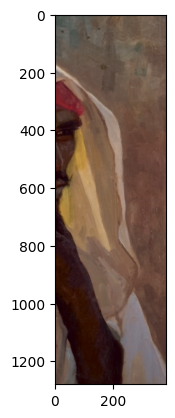

In [78]:
n_size = 128

def rgb_L_ab_(rgb_image, test_L):
    lab_array = color.rgb2lab(np.array(rgb_image))# Convert RGB to LAB colorspace
    lab_array[..., 0] = test_L #Change L channel to input
    rgb_array = color.lab2rgb(lab_array)# Convert back LAB to RGB colorspace
    rgb_array = (rgb_array * 255).astype(np.uint8)# Scale RGB values back to the range [0, 255]
    rgb_array = Image.fromarray(rgb_array, mode='RGB')# Convert RGB array back to image
    return rgb_array

def crop_(im):
    width, height = im.size
    data = []
    for j in range(0,int(height/n_size)):
        for i in range(0,int(width/n_size)):
            im1 = im.crop((0 + (n_size*i), 0 + (n_size*j), n_size + (n_size*i), n_size + (n_size*j)))
            im1 = np.array(im1)
            im1 = im1.astype(np.float32)
            im1 = im1/255
            data.append(im1)
    return data

filename = str("TEST_INPUT_[04] Coming into Bloom_V1.png")
test = Image.open(file_path+ "Testing/" + filename).convert('RGB')
test_L = color.rgb2lab(np.array(test))
test_L = test_L[..., 0]
w_dirty, h_dirty = test.size


autoencoder = keras.models.load_model(file_path + 'Model/unet_'+str(n_size)+'_rgb')


xx = int(w_dirty/n_size)
final=[]

for portion in range(0,xx):
    im1 = test.crop((n_size*portion, 0, (n_size*portion) + n_size, h_dirty))
    w1, h1 = im1.size
    w = int(w1/n_size)
    h = int(h1/n_size)

    neverbeforeseen = np.array(crop_(im1))
    #encoded_imgs = autoencoder.encoder(neverbeforeseen).numpy()
    decoded_imgs = autoencoder.predict(neverbeforeseen)

    col = np.vstack((decoded_imgs[0],decoded_imgs[1]))
    for i in range(2,h):
        col = np.vstack((col,decoded_imgs[i]))

    #y = np.where(col > 0.5,1,0) #round the values
    y = col
    y = (y * 255).astype('uint8')
    if portion == 0:
        final = y
    if portion > 0:
        final = np.hstack((final,y))


#final = lab_rgb_unnormalized(final)
#final = AB_rgb_unnormalized(final, test_L)
final = rgb_L_ab_(final, test_L)
final = np.squeeze(final)
reconstructed = Image.fromarray(final)
reconstructed.save(file_path + "Testing/"+"CLEAN128rgb_"+filename)
plt.imshow(reconstructed)